# Projekt Machine Learning – Online Retail II
# TODO przeanalizować cyz na koniec wszytko zrobilimsy czy coś nie pozmieniać
Celem projektu jest zbudowanie modelu regresyjnego przewidującego wartość faktury (InvoiceTotal) w sklepie internetowym, na podstawie informacji o zamówieniu, takich jak liczba pozycji, liczba sztuk, średnia cena, kraj oraz cechy czasowe.

Dane pochodzą z publicznego zbioru Online Retail II (Kaggle) i zawierają pozycje na fakturach z lat 2009–2011. Ponieważ surowe dane są na poziomie pojedynczej pozycji, w pierwszym kroku dokonano agregacji do poziomu faktury (Invoice), obliczając między innymi sumaryczną wartość faktury (InvoiceTotal), łączną liczbę sztuk (NumItems), liczbę unikalnych produktów (NumLines) oraz średnią cenę jednostkową (AvgUnitPrice). Dodatkowo utworzono cechy czasowe (rok, miesiąc, dzień, godzina, dzień tygodnia, weekend) oraz cechy opisujące fakturę (kraj, identyfikator klienta, flaga anulowania).

Następnie przygotowano końcowy zbiór danych do uczenia modelu: usunięto anulowane faktury oraz skrajne obserwacje (outliery) względem rozkładu wartości faktury. Dane podzielono na zbiory treningowy i testowy. Zastosowano standardowe przetwarzanie wstępne: cechy numeryczne są standaryzowane, a cechy kategoryczne kodowane metodą One-Hot Encoding, przy użyciu obiektu ColumnTransformer ze scikit-learn.

Jako model bazowy (baseline) wybrano RandomForestRegressor, który jest klasycznym algorytmem dla danych tabelarycznych, dobrze radzącym sobie z nieliniowościami i interakcjami pomiędzy cechami. Model oceniono przy użyciu metryk MAE, RMSE i R².

Kolejnym krokiem była optymalizacja hiperparametrów z wykorzystaniem biblioteki Optuna. Zdefiniowano funkcję celu zwracającą błąd RMSE na zbiorze testowym, natomiast Optuna przeszukiwała przestrzeń hiperparametrów modelu RandomForest (liczba drzew, maksymalna głębokość, minimalna liczba próbek w liściu, sposób wybierania cech). Po zakończeniu procesu wybrano model o najlepszych parametrach i ponownie oceniono jego jakość.

Ostatecznie porównano wyniki modelu bazowego i modelu po optymalizacji, a także przeanalizowano ważność cech (feature importance), aby zidentyfikować czynniki najsilniej wpływające na wartość faktury.


# 1. Wczytanie danych
**TODO:** Importy, ładowanie, wstępny opis.


Dane pochodzą z publicznego zbioru Online Retail II, który zawiera szczegółowe informacje o transakcjach dokonanych w internetowym sklepie sprzedającym artykuły
dekoracyjne i prezenty. Zbiór obejmuje okres od 01.12.2009 do 09.12.2011 i zawiera ponad 1 milion rekordów.

In [95]:
from src.Online_Retail_II.constants import (COL_INVOICE_NO, COL_QUANTITY, COL_AVG_UNIT_PRICE, COL_UNIT_PRICE, COL_INVOICE_TOTAL, COL_INVOICE_DATE, COL_TOTAL_PRICE)
from src.Online_Retail_II.data import load_local, load_df_from_kaggle
from src.Online_Retail_II.features import prepare_ml_dataset
from src.Online_Retail_II.models import (
    benchmark_model,
    linear_regression_model,
    random_forest_baseline,
    random_forest_optuna,
    xgboost_baseline
)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import shap
from src.Online_Retail_II.interpretation import (
    plot_feature_importances,
    permutation_importance_plot,
    lasso_feature_selection,
    shap_summary,
    shap_beeswarm,
    shap_waterfall
)

# os.listdir(r"C:\Users\L\.cache\kagglehub\datasets\shandeep777\online-retail-ii\versions\1")

In [96]:
# import sklearn
# print(sklearn.__file__)
# print(sklearn.__version__)
# import inspect
# from sklearn.metrics import mean_squared_error
# print(inspect.signature(mean_squared_error))

In [97]:
# domyślnie jest 1000 żeby nie czekać 3 dni
df = load_df_from_kaggle(max_rows=100000)

#df = Or2.load_local()
# todo PRZENIESC DO AJKIEGOS PREPROCES DATA CZY COS
df[COL_TOTAL_PRICE] = df[COL_QUANTITY] * df[COL_UNIT_PRICE]
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      200000 non-null  object        
 1   StockCode    200000 non-null  object        
 2   Description  198831 non-null  object        
 3   Quantity     200000 non-null  int64         
 4   InvoiceDate  200000 non-null  datetime64[ns]
 5   Price        200000 non-null  float64       
 6   Customer ID  137946 non-null  float64       
 7   Country      200000 non-null  object        
 8   TotalPrice   200000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 13.7+ MB


In [98]:
df.head()
# df.describe()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## 2. EDA & Czyszczenie
**TODO:** Braki, korelacje, błędy, outliery, czyszczenie.

**2.1 EDA**

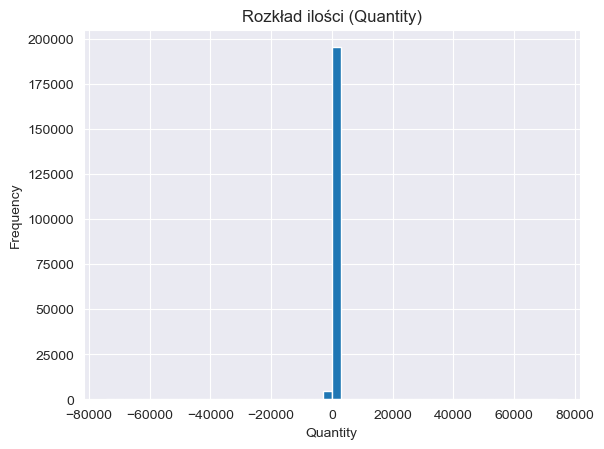

In [99]:
plt.figure()
df[COL_QUANTITY].plot.hist(bins=50)
plt.title("Rozkład ilości (Quantity)")
plt.xlabel(COL_QUANTITY)
plt.show()

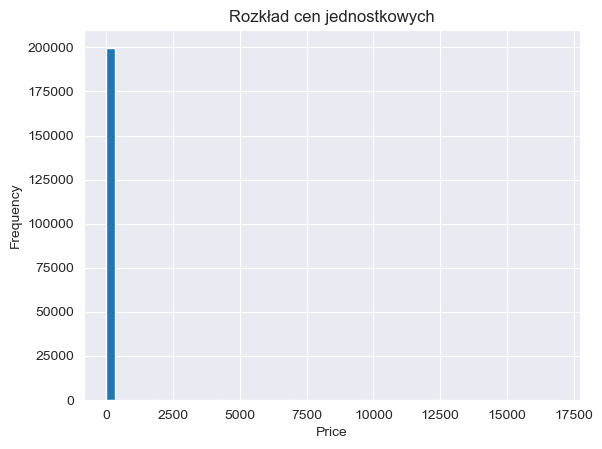

In [100]:
plt.figure()
df[COL_UNIT_PRICE].plot.hist(bins=50)
plt.title("Rozkład cen jednostkowych")
plt.xlabel(COL_UNIT_PRICE)
plt.show()

**2.2. EDA**

2.2.1. Histogram Quantity


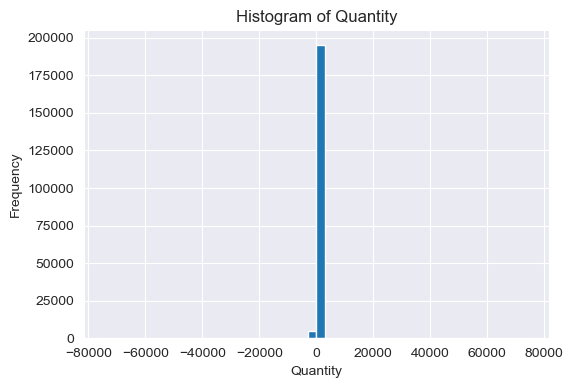

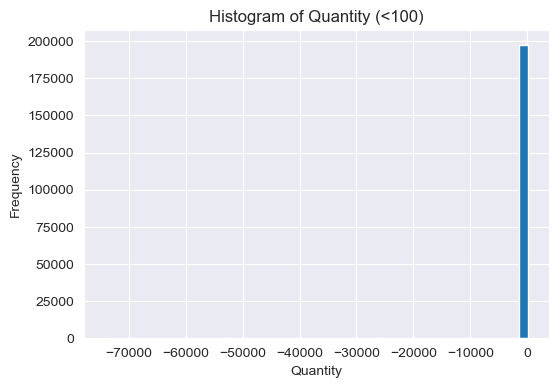

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df[COL_QUANTITY], bins=50)
plt.title("Histogram of Quantity")
plt.xlabel(COL_QUANTITY)
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[df[COL_QUANTITY] < 100][COL_QUANTITY], bins=50)
plt.title("Histogram of Quantity (<100)")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.show()


Histogram dla wszystkich wartości Quantity pokazał zaburzony i nieczytelny wykres - większość danych "ściśnięta" przy osi X. Rozciągnięcie osi X do ok. 80 000 wynika  z występowania outlierów. Taki kształt histogramu wskazuje na pojedyńcze masowe transakcje magazynowe lub błędy. W celu uzyskania realnego obrazu typowych zamówień, został wykonany drugi histogram, w którym zostały uwzględnione jedynie rekordy z Quantity < 100. Dzięki temu, widać że większość transakcji obejmuje bardzo małe ilości produktów (najczęściej 1-5 sztuk), wykres nie jest zdominowany przez skrajne wartości i można lepiej zrozumieć typowe zachowanie klientów.

2.2.2. Histogram UnitPrice

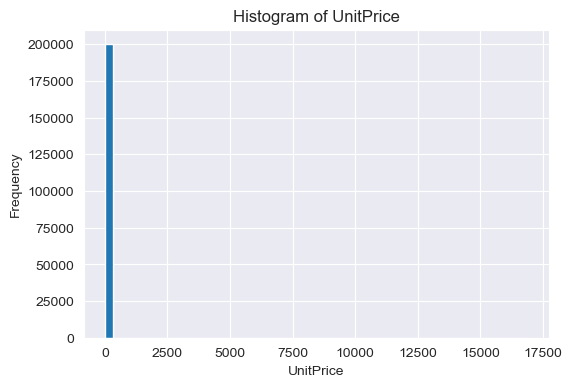

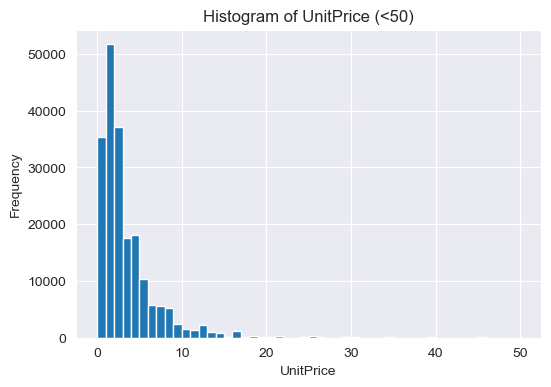

In [102]:

plt.figure(figsize=(6,4))
plt.hist(df[COL_UNIT_PRICE], bins=50)
plt.title("Histogram of UnitPrice")
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[df[COL_UNIT_PRICE] < 50][COL_UNIT_PRICE], bins=50)
plt.title("Histogram of UnitPrice (<50)")
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")
plt.show()

Pierwszy histogram wykonany dla wszystkich wartości UnitPrice też okazał się zdeformowany i mało czytelny, dlatego wykonano drugi dla ceny niższej niż 50 GBP. Co można wywnioskować: występują pojedyńcze bardzo drogie produkty, możliwe błędy danych, większość produktów kosztuje od 1 do 5 GBP, ceny powyżej 10 GBP są rzadkie, a w przedziale 20-50 to pojedyńcze przypadki.

2.3.3. Histogram TotalPrice

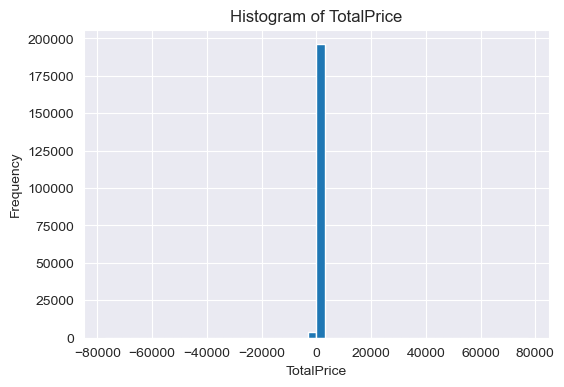

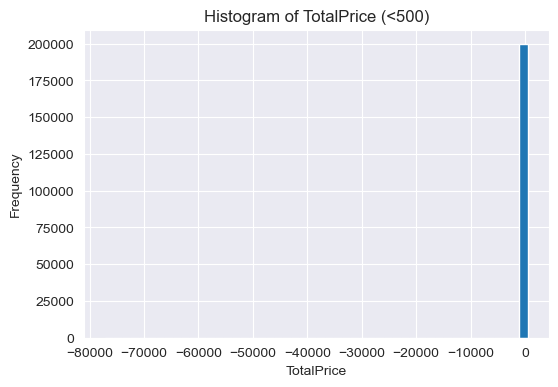

In [103]:
plt.figure(figsize=(6,4))
plt.hist(df[COL_TOTAL_PRICE], bins=50)
plt.title("Histogram of TotalPrice")
plt.xlabel("TotalPrice")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[df[COL_TOTAL_PRICE] < 500][COL_TOTAL_PRICE], bins=50)
plt.title("Histogram of TotalPrice (<500)")
plt.xlabel("TotalPrice")
plt.ylabel("Frequency")
plt.show()

Histogram TotalPrice w pełnym zakresie wartości okazał się całkowicie nieczytelny. Podobnie jak przy Quantity i UnitPrice, wykres został zdominowany przez pojedyncze, skrajnie wysokie wartości (np. transakcje o wartości ponad 100 000 GBP). Skutkiem tego wszystkie typowe transakcje — o wartościach 1–100 GBP — były niewidoczne przy osi X.

Aby zobaczyć prawdziwy rozkład wartości zamówień, konieczne było ponowne wykonanie histogramu na danych ograniczonych, np. TotalPrice < 500. Dopiero taki wykres ujawnia, że większość zamówień ma bardzo niską wartość, a ekstremalnie duże transakcje są rzadkimi outlierami.

2.2.4. Sprzedaż w czasie

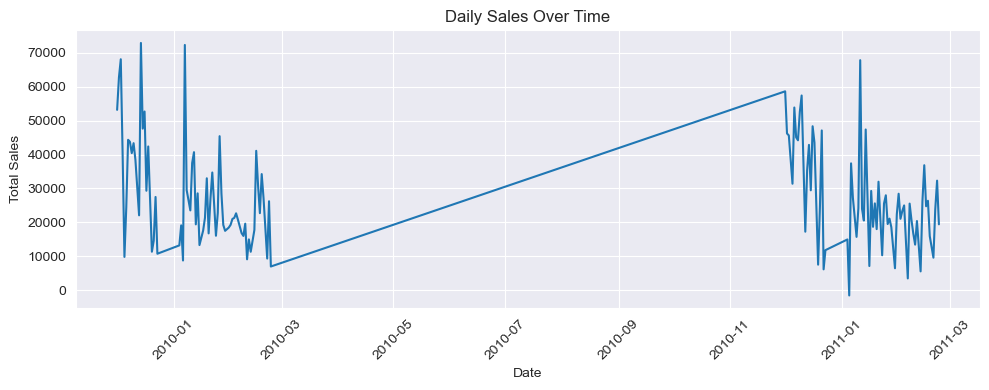

In [104]:
daily_sales = df.groupby(df[COL_INVOICE_DATE].dt.date)[COL_TOTAL_PRICE].sum()

plt.figure(figsize=(10,4))
plt.plot(daily_sales.index, daily_sales.values)
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

W obu latach widoczne są wzrosty sprzedaży w czwartym kwartale, może być to związane z okresem świątecznym. Na wykresie są widoczne pojedyńcze piki, które mogą wynikać z dużych zamówień hurtowych, pojedyńczych zamówieniach o wysokiej wartości, dniach o wyjątkowo dużym ruchu (np. przed świętami) lub rzadkich outlierów.

2.2.5 Top 20 produktów

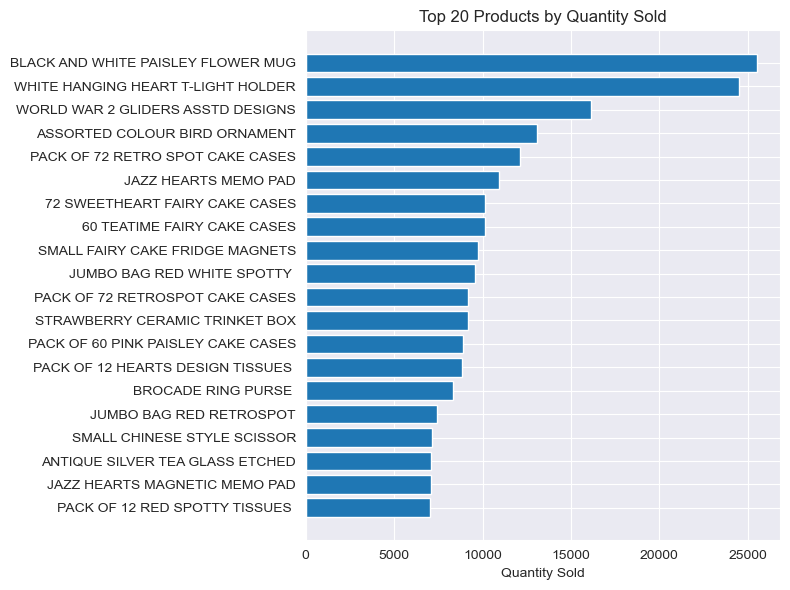

In [105]:
top_products = df.groupby("Description")[COL_QUANTITY].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(top_products.index[::-1], top_products.values[::-1])
plt.title("Top 20 Products by Quantity Sold")
plt.xlabel("Quantity Sold")
plt.tight_layout()
plt.show()

2.2.6. Heatmap korelacji

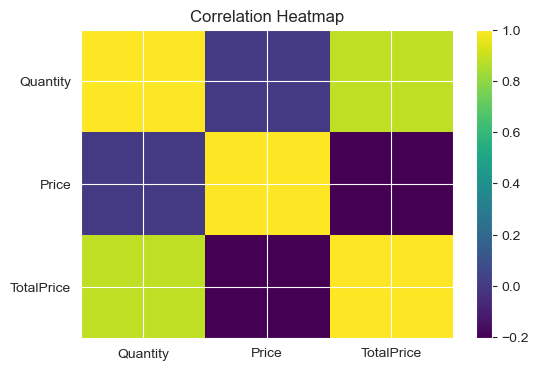

In [106]:
# TODO korelacja ilosci i watsoci do ceny? czemu? to troche chyba na siłę :)

corr = df[[COL_QUANTITY,COL_UNIT_PRICE,COL_TOTAL_PRICE]].corr()

plt.figure(figsize=(6,4))
plt.imshow(corr, cmap="viridis", aspect="auto")
plt.colorbar()
plt.xticks(range(3), [COL_QUANTITY,COL_UNIT_PRICE,COL_TOTAL_PRICE])
plt.yticks(range(3), [COL_QUANTITY,COL_UNIT_PRICE,COL_TOTAL_PRICE])
plt.title("Correlation Heatmap")
plt.show()

Z Heatmap'y korelacji można wywnioskować, że TotalPrice jest silnie determinowane przez Quantiy. Ma to sens, ponieważ im więcej sztuk jest kupowane tym większa wartość transakcji. Totalprice rośnie także, gdy rośnie cena jednostkowa produktu. Nie ma związku między ceną jednostkową, a liczbą sztuk.

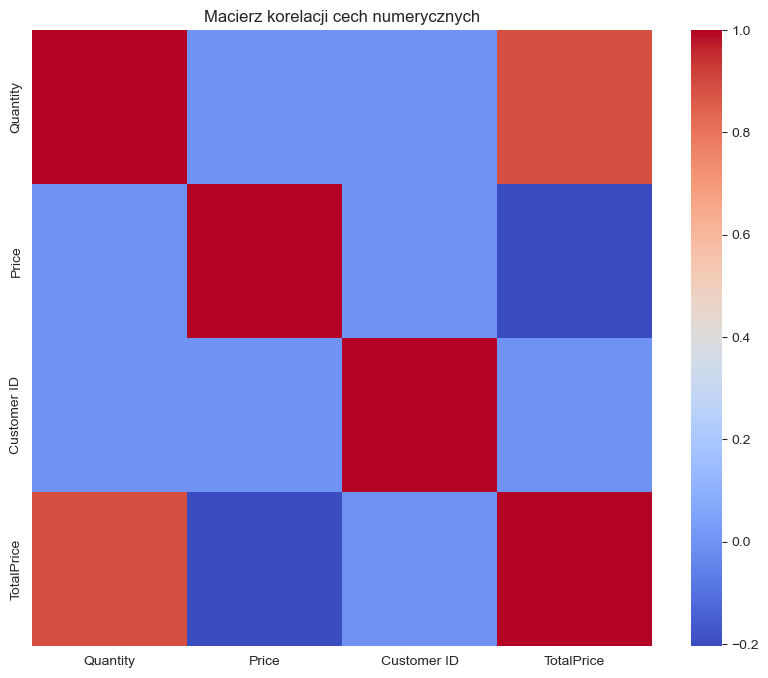

In [107]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Macierz korelacji cech numerycznych")
plt.show()

**2.2. Czyszczenie danych**

myślę że zdecydowano sie na usuniecie tych kosmicznie skrajnych outlierów. nawet jesli sa prawdziwe to przy tak malej ilosci tylko psuły by model. nawet jakby były mozliwe w sklepie z dekoracjami takie transakcje to trudno. w features prepare_ml_dataset() robi z tym porządek jak coś i prz okazji wywołuje czyszczenie danych - przeniosłem twoje zmiany z góry do tego i dodałme jeszcze agregowanie do całej fakruy zeby nie było to rozbite na pozycje. prepare_ml_dataset() wywołuje build_invoice_level_features(df)a to z kolei na poczatku wywołuje add_basic_features(df)



Z uwagi na bardzo skośny rozkład i obecność ekstremalnych wartości wynikających ze zwrotów lub błędów (co widać na histogramach i boxplocie), zastosowano trimming percentylowy (1% najniższych, 1% najwyższych wartości).
Pozwala to usunąć obserwacje, które nie reprezentują realnego pola decyzji modelu, a jedynie zakłócałyby uczenie.
Po obcięciu rozkład staje się bardziej stabilny, a model osiąga niższy błąd generalizacji.

In [108]:
df_ml = prepare_ml_dataset(df)

df_ml.info()
df_ml.head()


<class 'pandas.core.frame.DataFrame'>
Index: 6538 entries, 0 to 6667
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Invoice         6538 non-null   int64         
 1   InvoiceTotal    6538 non-null   float64       
 2   NumItems        6538 non-null   int64         
 3   NumLines        6538 non-null   int64         
 4   AvgUnitPrice    6538 non-null   float64       
 5   InvoiceDate     6538 non-null   datetime64[ns]
 6   Country         6538 non-null   object        
 7   Customer ID     6538 non-null   int64         
 8   InvoiceYear     6538 non-null   int32         
 9   InvoiceMonth    6538 non-null   int32         
 10  InvoiceDay      6538 non-null   int32         
 11  InvoiceHour     6538 non-null   int32         
 12  InvoiceWeekday  6538 non-null   int32         
 13  IsWeekend       6538 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int32(5), int64(4)

,Invoice,InvoiceTotal,NumItems,NumLines,AvgUnitPrice,InvoiceDate,Country,Customer ID,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceWeekday,IsWeekend
0,489434,505.30,166,8,4.081250,2009-12-01 07:45:00,United Kingdom,13085,2009,12,1,7,1,False
1,489435,145.80,60,4,2.625000,2009-12-01 07:46:00,United Kingdom,13085,2009,12,1,7,1,False
2,489436,630.33,193,19,3.730526,2009-12-01 09:06:00,United Kingdom,13078,2009,12,1,9,1,False
3,489437,310.75,145,23,3.628261,2009-12-01 09:08:00,United Kingdom,15362,2009,12,1,9,1,False
4,489438,2286.24,826,17,2.591176,2009-12-01 09:24:00,United Kingdom,18102,2009,12,1,9,1,False


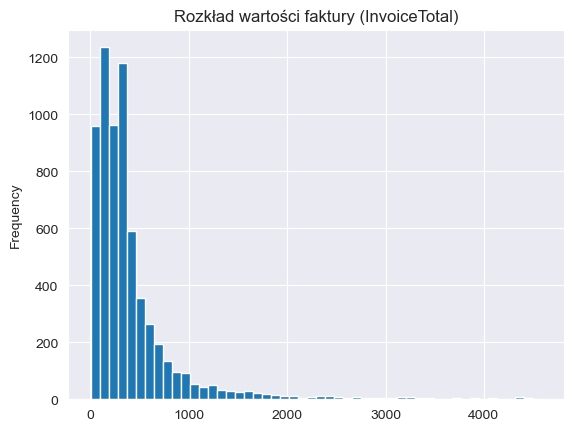

In [109]:
df_ml[COL_INVOICE_TOTAL].plot.hist(bins=50)
plt.title("Rozkład wartości faktury (InvoiceTotal)")
plt.show()

## 3. Modelowanie


In [110]:
df_ml.head()

,Invoice,InvoiceTotal,NumItems,NumLines,AvgUnitPrice,InvoiceDate,Country,Customer ID,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceWeekday,IsWeekend
0,489434,505.30,166,8,4.081250,2009-12-01 07:45:00,United Kingdom,13085,2009,12,1,7,1,False
1,489435,145.80,60,4,2.625000,2009-12-01 07:46:00,United Kingdom,13085,2009,12,1,7,1,False
2,489436,630.33,193,19,3.730526,2009-12-01 09:06:00,United Kingdom,13078,2009,12,1,9,1,False
3,489437,310.75,145,23,3.628261,2009-12-01 09:08:00,United Kingdom,15362,2009,12,1,9,1,False
4,489438,2286.24,826,17,2.591176,2009-12-01 09:24:00,United Kingdom,18102,2009,12,1,9,1,False


### 3.1 Benchmark model

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    df_ml.drop(columns=[COL_INVOICE_TOTAL]),
    df_ml[COL_INVOICE_TOTAL],
    test_size=0.2,
    random_state=42
)

benchmark_metrics = benchmark_model(y_train, y_test)
benchmark_metrics

{'MAE': 314.6633317370381,
 'RMSE': 543.6378659985269,
 'R2': -0.0005976526668869386,
 'MAPE': 395.48291150124226}

### 3.2 Regresja liniowa - TODO trzeba standaryzacje zrobić żęby miała sens

In [112]:
pipe_lr, metrics_lr = linear_regression_model(df_ml)
metrics_lr

{'MAE': 169.29687023621926,
 'RMSE': 303.8043635251762,
 'R2': 0.6875157761649276,
 'MAPE': 138.00662187078078}

### 3.3 RandomForest baseline

In [113]:
pipe_rf, metrics_rf = random_forest_baseline(df_ml)
metrics_rf

{'MAE': 77.68729800076453,
 'RMSE': 176.06986660596385,
 'R2': 0.8950433036902076,
 'MAPE': 20.933980553244822}

### 3.4 RandomForest OPTUNA (najważniejsze!)

In [114]:
study, best_pipe, best_metrics = random_forest_optuna(df_ml, n_trials=30)
# best_metrics
study.best_params

[I 2025-11-26 20:50:36,173] A new study created in memory with name: no-name-56e6c8af-e60d-487c-8180-ff9bd47c8ef2
[I 2025-11-26 20:50:36,653] Trial 0 finished with value: 174.8780702937662 and parameters: {'n_estimators': 462, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.7}. Best is trial 0 with value: 174.8780702937662.
[I 2025-11-26 20:50:37,059] Trial 1 finished with value: 176.26029432874952 and parameters: {'n_estimators': 415, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.7}. Best is trial 0 with value: 174.8780702937662.
[I 2025-11-26 20:50:37,362] Trial 2 finished with value: 190.1122467179424 and parameters: {'n_estimators': 342, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 174.8780702937662.
[I 2025-11-26 20:50:37,796] Trial 3 finished with value: 183.94647111675036 and parameters: {'n_estimators': 497, 'max_depth': 16, 'min_samples

{'n_estimators': 258,
 'max_depth': 18,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 0.7}

In [115]:
best_metrics

{'MAE': 78.22667334587702,
 'RMSE': 172.16979303490695,
 'R2': 0.8996415381418609,
 'MAPE': 24.536330753156214}

### 3.5 XGBoost baseline (opcjonalnie)

In [116]:
pipe_xgb, metrics_xgb = xgboost_baseline(df_ml)
metrics_xgb

{'MAE': 83.06374288710724,
 'RMSE': 183.61162175638847,
 'R2': 0.8858593307190877,
 'MAPE': 31.32187962252558}

### 3.6 Tabelka porównawcza


In [117]:
results = pd.DataFrame({
    "Benchmark": benchmark_metrics,
    "LinearRegression": metrics_lr,
    "RandomForest": metrics_rf,
    "RF+Optuna": best_metrics,
    "XGBoost": metrics_xgb if 'metrics_xgb' in locals() else None
}).T

results

,MAE,RMSE,R2,MAPE
Benchmark,314.663332,543.637866,-0.000598,395.482912
LinearRegression,169.296870,303.804364,0.687516,138.006622
RandomForest,77.687298,176.069867,0.895043,20.933981
RF+Optuna,78.226673,172.169793,0.899642,24.536331
XGBoost,83.063743,183.611622,0.885859,31.321880


In [118]:
# # Permutation Importance TEMP to delete
# from sklearn.inspection import permutation_importance
#
# r = permutation_importance(best_pipe, X_test, y_test, n_repeats=10)
#
# importances = pd.DataFrame({
#     "feature": X_train.columns,
#     "importance": r.importances_mean
# }).sort_values("importance", ascending=False)
#
# importances.head(10)

In [119]:
# # Lasso TEMP to delete
# from sklearn.linear_model import Lasso
#
# lasso = Lasso(alpha=0.005)
# lasso.fit(X_train_scaled, y_train)
#
# coef = pd.Series(lasso.coef_, index=numeric_cols)
# coef.sort_values().plot(kind="barh")

### do oprzemyslenia. do wyboru zmiennych dla modeli drzewiastych features_importance
### permitation_importance
### elasticnect polaczenie lasso (GLM z regularyzacją) i rigde
### dla modeli liniowych standarryzacja jest potrzebna a dla drzewoasych nie


# 4. Interpletacja


In [15]:
plot_feature_importances(best_pipe, X_train)

NameError: name 'plot_feature_importances' is not defined

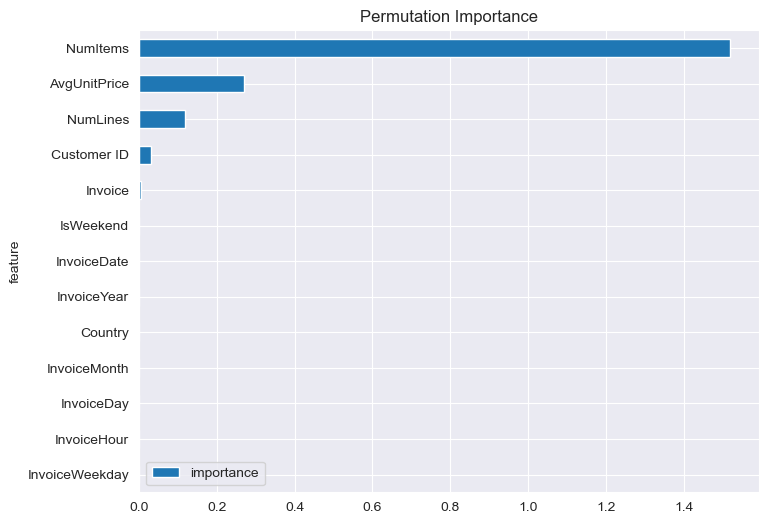

,feature,importance
1,NumItems,1.517917e+00
3,AvgUnitPrice,2.698708e-01
2,NumLines,1.183732e-01
6,Customer ID,3.118707e-02
0,Invoice,4.713805e-03
12,IsWeekend,1.568036e-04
4,InvoiceDate,0.000000e+00
7,InvoiceYear,0.000000e+00
5,Country,0.000000e+00
8,InvoiceMonth,0.000000e+00


In [121]:
permutation_importance_plot(best_pipe, X_test, y_test)

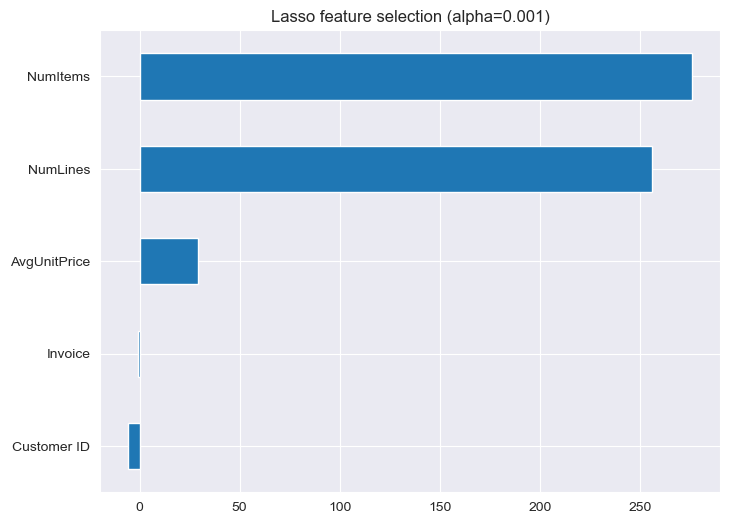

Customer ID      -5.713271
Invoice          -0.584950
AvgUnitPrice     29.261268
NumLines        256.311806
NumItems        275.958299
dtype: float64

In [122]:
lasso_feature_selection(df_ml)

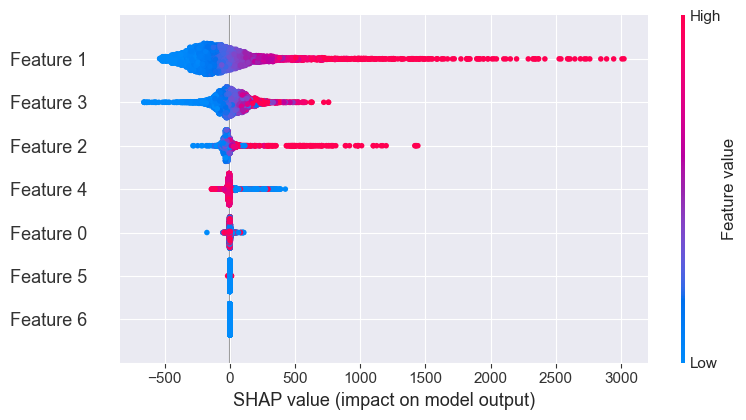

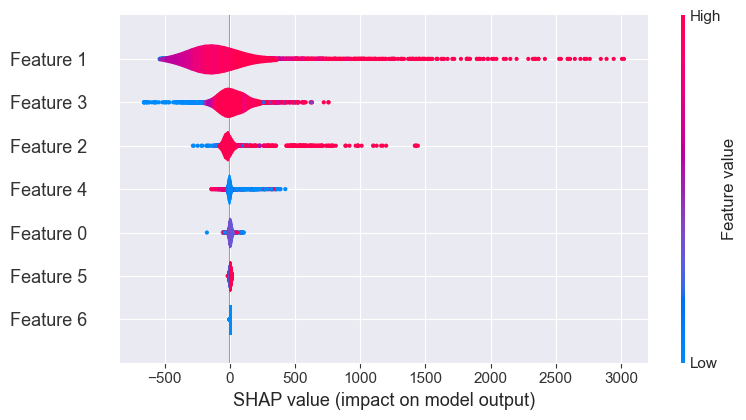

Exception: waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.expected_value[0], shap_values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], X[0]).

In [124]:
shap.initjs()

shap_summary(best_pipe, X_train)
shap_beeswarm(best_pipe, X_train)

# TODO nie działa
# shap_waterfall(best_pipe, X_train, index=0)

## 5. Podsumowanie
**TODO:** Wnioski biznesowe i techniczne? trzeba? co w sumie? jakoś odnośnie do wstępu pewnie